# My generative adversarial network (CycleGAN) for translating a regular image into an image in the style of a Claude Monet painting

In [3]:
# load the necessary libraries
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
from torch.nn import init
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import math

# fix random seed for reproducibility of results
# determine the device for training on the GPU
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = 'mps'

In [4]:
# initialize variables with the data directory
dir_monet = 'gan-getting-started/monet/monet'
dir_photo = 'gan-getting-started/photo/photo'
# making a list of file names with daily photographs and paintings by Monet
files_monet = [name for name in os.listdir(dir_monet) if os.path.splitext(name)[-1] == '.jpg']
files_photo = [name for name in os.listdir(dir_photo) if os.path.splitext(name)[-1] == '.jpg']


In [5]:
# initializing tensors for loading data 
monet = torch.zeros(30, 3, 256, 256, dtype=torch.uint8)
photo = torch.zeros(500, 3, 256, 256, dtype=torch.uint8)
# filling tensors with image data
for i, filename in enumerate(files_monet):
    monet[i] = torchvision.io.read_image(os.path.join(dir_monet, filename))
for i, filename in enumerate(files_photo):
    photo[i] = torchvision.io.read_image(os.path.join(dir_photo, filename))

In [6]:
# let's check the size of the resulting tensor with Monet images
monet.shape

torch.Size([30, 3, 256, 256])

In [7]:
# let's check the size of the resulting tensor with images
photo.shape

torch.Size([500, 3, 256, 256])

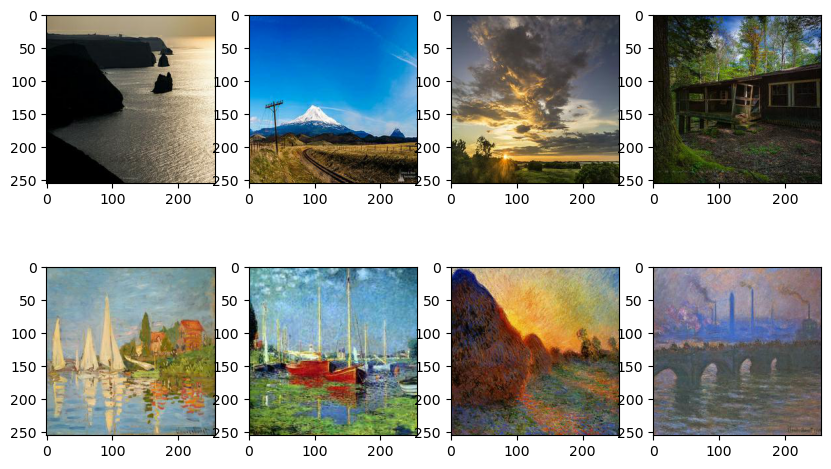

In [8]:
# try to display the resulting data, take the first 4 images, to display them correctly,
# swap the order of measurements to Height x Width x Channel
plt.figure(figsize=(10,6))

for i, img in enumerate(photo[:4]):
  plt.subplot(2,4,i+1)
  plt.imshow(img.permute(1, 2, 0)) 

for i, img in enumerate(monet[:4]):
  plt.subplot(2,4,i+5)
  plt.imshow(img.permute(1, 2, 0)) 
    
#plt.show()

In [9]:
# define the normalization and inverse functions to bring the data to the range (-1, 1)
def normalize(image):
    image = (image / 127.5) - 1
    return image

def denormalize(image):
    image = (image * 0.5 + 0.5) * 255
    image = image.int()  
    return image

In [10]:
# let's see what happened: normalize the last photo from the sample
norm = normalize(photo[-1])

In [11]:
# let's denormalize it
denormalize(norm)

tensor([[[247, 247, 246,  ..., 176, 176, 176],
         [245, 245, 244,  ..., 177, 177, 176],
         [244, 243, 243,  ..., 180, 179, 177],
         ...,
         [ 61,  58,  66,  ...,  78, 116, 146],
         [ 52,  67,  76,  ...,  85, 119, 162],
         [ 67,  73,  67,  ..., 128, 128, 139]],

        [[164, 162, 162,  ..., 163, 163, 163],
         [162, 160, 160,  ..., 163, 163, 163],
         [159, 158, 159,  ..., 163, 162, 163],
         ...,
         [ 81,  78,  85,  ...,  78, 115, 145],
         [ 72,  86,  95,  ...,  83, 118, 160],
         [ 86,  92,  86,  ..., 124, 125, 137]],

        [[122, 121, 118,  ..., 181, 181, 181],
         [120, 119, 116,  ..., 180, 180, 181],
         [118, 117, 115,  ..., 179, 180, 180],
         ...,
         [ 98,  95, 102,  ...,  66,  97, 124],
         [ 89, 103, 112,  ...,  71,  98, 137],
         [103, 109, 103,  ..., 112, 106, 114]]], dtype=torch.int32)

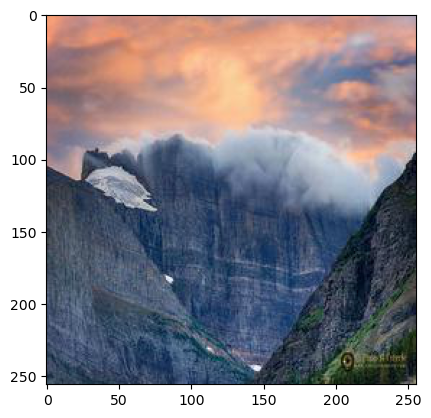

In [12]:
# displaying the resulting data
plt.imshow(denormalize(norm).permute(1, 2, 0))

In [13]:
# normalize tensors for loading: 500 photographs, all 30 paintings
photo_norm = torch.FloatTensor()

for i in range(len(photo)):
    photo_norm = torch.cat((photo_norm, normalize(photo[i]).unsqueeze(dim = 0)),dim = 0)

monet_norm = torch.FloatTensor()

for i in range(len(monet)):
    monet_norm = torch.cat((monet_norm, normalize(monet[i]).unsqueeze(dim = 0)),dim = 0)

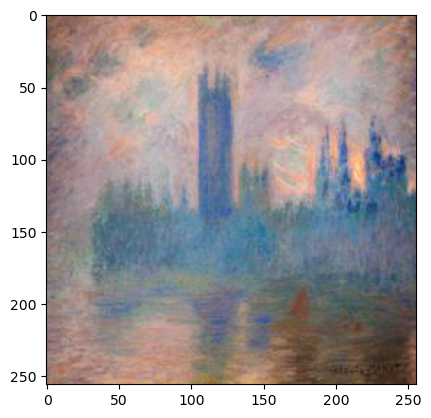

In [14]:
# let's look at a random painting, the paintings by K. Monet are too good!!!
i = random.randint(0, 30)
plt.imshow(denormalize(monet_norm[i]).permute(1, 2, 0))

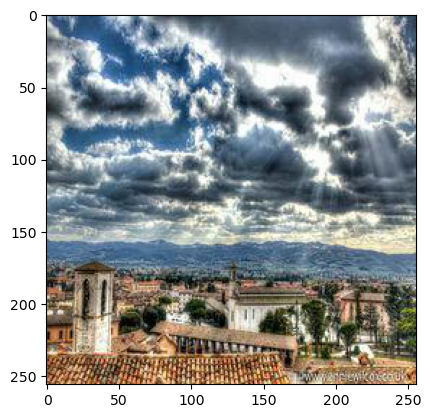

In [15]:
# let's look at a random photo
i = random.randint(0, 500)
plt.imshow(denormalize(photo_norm[i]).permute(1, 2, 0))

In [16]:
photo_norm.shape

torch.Size([500, 3, 256, 256])

In [31]:
# select the size of the batches: test, for training and batch for loading the batch for training
batch_size_test = 1
batch_size = 1
load_for_batch = 5
# load test batches, mixing them, take the last 100 for photos
test_dataloader_Y = torch.utils.data.DataLoader(monet_norm, batch_size=batch_size_test, shuffle=True, 
                                                num_workers=0, pin_memory=True)
test_dataloader_X = torch.utils.data.DataLoader(photo_norm[-100:], batch_size=batch_size_test, shuffle=True, 
                                                num_workers=0, pin_memory=True)
# loading batches to load batches for training - to increase learning speed
loader_for_batch_Y = torch.utils.data.DataLoader(monet_norm, batch_size=load_for_batch, shuffle=True,
                                           num_workers=0, pin_memory=True)
loader_for_batch_X = torch.utils.data.DataLoader(photo_norm[:400], batch_size=load_for_batch, shuffle=True,
                          num_workers=0, pin_memory=True)
# make it possible to iterate over the batch for training, we get the first batch
loader_iter_batch_Y = iter(loader_for_batch_Y)
loader_iter_batch_X = iter(loader_for_batch_X)
loader_Y = next(loader_iter_batch_Y)
loader_X = next(loader_iter_batch_X)

In [18]:
# let's take a look and check the size of the downloaded data with batches
print(len(test_dataloader_Y), len(test_dataloader_X), len(loader_for_batch_Y), len(loader_for_batch_X))

30 100 6 80


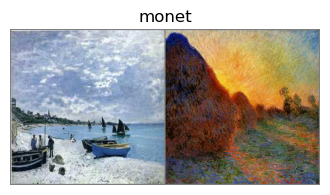

In [19]:
# want to make sure that everything is in order, that it hasn’t disappeared anywhere, plus we want to look
# at the work of make_grid along with denormalization
# continue to admire the paintings and photographs
loader_for_Y = torch.utils.data.DataLoader(loader_Y, batch_size=load_for_batch, shuffle=True,
                                           num_workers=0, pin_memory=True)
loader_for_X = torch.utils.data.DataLoader(loader_X, batch_size=load_for_batch, shuffle=True,
                          num_workers=0, pin_memory=True)
dataiter = iter(loader_for_Y)
im_norm = next(dataiter)[:2]
grid_norm = torchvision.utils.make_grid(im_norm, nrow=2).permute(1, 2, 0).detach()
grid_denorm = denormalize(grid_norm)
fig = plt.figure(figsize=(4, 4))
plt.imshow(grid_denorm)
plt.axis('off')
plt.title('monet')
plt.show()

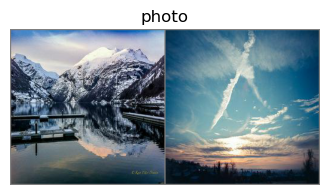

In [20]:
dataiter = iter(loader_for_X)
im_norm = next(dataiter)[:2]
grid_norm = torchvision.utils.make_grid(im_norm, nrow=5).permute(1, 2, 0).detach()#.numpy()
grid_denorm = denormalize(grid_norm)
fig = plt.figure(figsize=(4, 4))
plt.imshow(grid_denorm)
plt.axis('off')
plt.title('photo')
plt.show()

In [21]:
im_norm.shape

torch.Size([2, 3, 256, 256])

In [22]:
# let's start creating CycleGAN
# creating a Discriminator to determine whether an image is real or not
# consists of 5 convolutional layers with different parameters, with normalization and activation function LeakyReLU
class Discriminator(nn.Module):
    def __init__(self, conv_dim = 64):
        super(Discriminator, self).__init__()
        # layers
        self.main = nn.Sequential(
            
        nn.Conv2d(in_channels = 3, out_channels = conv_dim, kernel_size = 4, stride = 1, padding =1),
        nn.LeakyReLU(negative_slope = 0.2, inplace = True),
           
        nn.Conv2d(in_channels = conv_dim, out_channels = conv_dim * 2, kernel_size = 4, stride = 1, padding =1),
        nn.InstanceNorm2d(conv_dim * 2),
        nn.LeakyReLU(negative_slope = 0.2, inplace = True),
            
        nn.Conv2d(in_channels = conv_dim * 2, out_channels = conv_dim * 4, kernel_size = 4, stride = 2, padding =1),
        nn.InstanceNorm2d(conv_dim * 4),
        nn.LeakyReLU(negative_slope = 0.2, inplace = True),
            
        nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim*8, kernel_size = 4, stride = 2, padding =1),
        nn.InstanceNorm2d(conv_dim * 8),
        nn.LeakyReLU(negative_slope = 0.2, inplace = True),
            
        nn.Conv2d(in_channels = conv_dim * 8, out_channels = 1, kernel_size = 4, stride = 2, padding =1),
           
        )
    # direct pass
    def forward(self, input):
        return self.main(input)
# looking at the model using summary
model = Discriminator()
print(model)
summary(model, (3, 256, 256))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
----------------------------------------------------------------
        Layer 

In [23]:
# create a Generator consisting of an encoder, 9 residual blocks, and a decoder
# the encoder is 3 convolutional layers with different parameters,
# with normalization and with the ReLU activation function
# residual blocks - 2 convolutional layers with the same parameters, with normalization and,
# in the first case, with an activation function
# decoder - the opposite operation to convolution, consists of 3 transposed convolutional layers with different 
# parameters, with normalization with activation functions ReLU, Tanh at the output to obtain the input range 
# of values (-1, 1)
class Generator(nn.Module):
    def __init__(self, conv_dim = 64):
        super(Generator, self).__init__()
        # the encoder
        self.code = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels = 3, out_channels = conv_dim, kernel_size = 7, stride = 1), # (128, 128, 64)
            nn.InstanceNorm2d(conv_dim),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = conv_dim, out_channels = conv_dim * 2, kernel_size = 4, stride=2, padding=1), # (64, 64, 128)
            nn.InstanceNorm2d(conv_dim * 2),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = conv_dim * 2, out_channels = conv_dim * 4, kernel_size = 4, stride=2, padding=1), # (32, 32, 256)
            nn.InstanceNorm2d(conv_dim * 4),
            nn.ReLU(inplace = True)
            )
            # Residual blocks 
        self.res1 = nn.Sequential(
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            nn.ReLU(inplace = True),
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            )
        self.res2 = nn.Sequential(
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            nn.ReLU(inplace = True),
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            )
        self.res3 = nn.Sequential(
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            nn.ReLU(inplace = True),
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            )
        self.res4 = nn.Sequential(
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            nn.ReLU(inplace = True),
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            )
        self.res5 = nn.Sequential(
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            nn.ReLU(inplace = True),
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            )
        self.res6 = nn.Sequential(
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            nn.ReLU(inplace = True),
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            )
        self.res7 = nn.Sequential(
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            nn.ReLU(inplace = True),
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            )
        self.res8 = nn.Sequential(
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            nn.ReLU(inplace = True),
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            )
        self.res9 = nn.Sequential(
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            nn.ReLU(inplace = True),
            #nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels = conv_dim * 4, out_channels = conv_dim * 4, kernel_size = 3, stride=1, padding=1),
            nn.InstanceNorm2d(conv_dim * 4),
            )
            # the decoder
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(conv_dim*2),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(conv_dim),
            nn.ReLU(inplace = True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=conv_dim, out_channels=3, kernel_size=7, stride = 1),
            #nn.InstanceNorm2d(3),
            #nn.ReLU(inplace = True),
            nn.Tanh()
            )
    # direct pass involving signal amplification by adding input to output in Residual Blocks layers
    def forward(self, x):
        out = self.code(x)
        out1 = out + self.res1(out)
        out2 = out1 + self.res2(out1)
        out3 = out2 + self.res3(out2)
        out4 = out3 + self.res4(out3)
        out5 = out4 + self.res5(out4)
        out6 = out5 + self.res6(out5)
        out7 = out6 + self.res7(out6)
        out8 = out7 + self.res8(out7)
        out9 = out8 + self.res9(out8)
        out = self.decode(out9)
        return out
# looking at the model using summary    
model = Generator()
print(model)
summary(model, (3, 256, 256))

Generator(
  (code): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(256, eps=1e-05, moment

In [32]:
# the function of initializing weights in convolutional layers with values of a normal distribution
# with a given mathematical expectation and standard deviation
def weights_init(m):
    classname = m.__class__.__name__
    std_dev = 0.02
    mean = 0.0
    if hasattr(m, 'weight') and (classname.find('Conv') != -1):
        init.normal_(m.weight.data, mean, std_dev)

In [33]:
# function for initializing the components of the model: 2 Generators and 2 Discriminators, initializing 
# network weights and moving to GPU
def my_gan(g_dim=64, d_dim=64):

    G_X_Y = Generator(conv_dim=g_dim)
    G_Y_X = Generator(conv_dim=g_dim)

    D_X = Discriminator(conv_dim=d_dim)
    D_Y = Discriminator(conv_dim=d_dim) 

    G_X_Y.apply(weights_init)
    G_Y_X.apply(weights_init)
    D_X.apply(weights_init)
    D_Y.apply(weights_init)
    
    device = torch.device("mps")
    G_X_Y.to(device)
    G_Y_X.to(device)
    D_X.to(device)
    D_Y.to(device)

    return G_X_Y, G_Y_X, D_X, D_Y

In [34]:
# creating and initializing the CycleGAN Model
G_X_Y, G_Y_X, D_X, D_Y = my_gan()

In [35]:
# defining Error Functions for the Generator and Discriminator
# adversarial error (mean square error) of determining the authenticity of an image
def real_mse_loss(D_out):
    mse_loss = 0.5 * torch.mean((D_out-1)**2)
    return mse_loss
# adversarial error (mean square error) of determining the generated image 
def unreal_mse_loss(D_out):
    mse_loss = 0.5 * torch.mean(D_out**2)
    return mse_loss
# cycle consistency error
def cycle_consist_loss(real_img, restored_img, lambda_w=10):
    restored_loss = torch.mean(torch.abs(real_img - restored_img))
    return lambda_w*restored_loss 

In [36]:
# setting optimizers and their parameters
lr = 0.001 
beta1 = 0.500 
beta2 = 0.999
eps = 1e-08
g_parameters = list(G_X_Y.parameters()) + list(G_Y_X.parameters())

G_optimizer = optim.Adam(g_parameters, lr, [beta1, beta2], eps = eps)
D_X_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2], eps = eps)
D_Y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2], eps = eps)

In [37]:
# GAN training function, input parameters: batch loaders for testing and for loading batches for training,
# number of batches in an epoch, number of epochs
def train_gan(loader_for_batch_X, loader_for_batch_Y, test_dataloader_X, 
              test_dataloader_Y, batches_in_epoch = 5, n_epochs = 1000):
    # set the batch size for training, initialize the list of errors of the discriminator and generator
    batch_size = 1
    losses = []
    # let's transform the batch loader for training and testing into iterable ones
    loader_iter_batch_Y = iter(loader_for_batch_Y)
    loader_iter_batch_X = iter(loader_for_batch_X)
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)
    # putting GAN components into training mode
    G_Y_X.train()
    G_X_Y.train()
    D_Y.train()
    D_X.train()
    # go by epochs within the passed parameter
    for epoch in range(1, n_epochs+1): 
        # if you run out of batches to download training batches
        # again transform the batches for loading batches for training into iterable ones 
        if epoch % 6 == 0:
            loader_iter_batch_Y = iter(loader_for_batch_Y)
        if epoch % 80 == 0:
            loader_iter_batch_X = iter(loader_for_batch_X)
        # take the batch in order and load batches from it for training
        loader_X = next(loader_iter_batch_X)
        loader_Y = next(loader_iter_batch_Y)
        dataloader_X = torch.utils.data.DataLoader(loader_X, batch_size=batch_size, shuffle=True,
                          num_workers=0, pin_memory=True)
        dataloader_Y = torch.utils.data.DataLoader(loader_Y, batch_size=batch_size, shuffle=True,
                                           num_workers=0, pin_memory=True) 
        # reset errors in the epoch, convert batches for training to iterable ones
        D_epoch_loss = 0.0
        G_epoch_loss = 0.0
        iter_X = iter(dataloader_X)
        iter_Y = iter(dataloader_Y)
        # go through the batches within the passed parameter
        for batch in range(1, batches_in_epoch+1):
            print(epoch, batch)
            # take the batch in order and transfer it to the GPU
            images_X = next(iter_X)
            images_Y = next(iter_Y)
            images_X = images_X.to(device)
            images_Y = images_Y.to(device)
            # needed to catch errors
            with torch.autograd.set_detect_anomaly(True):
                # run a real photograph through the appropriate discriminator and calculate the error
                D_X_optimizer.zero_grad()
                D_out_X = D_X(images_X)
                D_X_real_loss = real_mse_loss(D_out_X)
                # generate an image, run it through the appropriate discriminator, and calculate the error
                unreal_X = G_Y_X(images_Y)
                D_out_X = D_X(unreal_X)
                D_X_unreal_loss = unreal_mse_loss(D_out_X)
                # get the total error, do a reverse pass, a gradient step
                D_X_loss = D_X_real_loss + D_X_unreal_loss
                D_X_loss.backward()
                D_X_optimizer.step()
                # run a real Monet painting through the appropriate discriminator and calculate the error
                D_Y_optimizer.zero_grad()
                D_out_Y = D_Y(images_Y)
                D_Y_real_loss = real_mse_loss(D_out_Y)
                # generate an image, run it through the appropriate discriminator, and calculate the error
                unreal_Y = G_X_Y(images_X)
                D_out_Y = D_Y(unreal_Y)
                D_Y_unreal_loss = unreal_mse_loss(D_out_Y)
                # get the total error, do a reverse pass, a gradient step
                D_Y_loss = D_Y_real_loss + D_Y_unreal_loss
                D_Y_loss.backward()
                D_Y_optimizer.step()
                # count the error in the batch based on discriminators and display it
                D_batch_loss = D_X_real_loss + D_X_unreal_loss + D_Y_real_loss + D_Y_unreal_loss
                print('D_batch_loss', D_batch_loss.item())
                # generate a photograph based on Monet’s painting, run it through the appropriate generator,
                # want the discriminator to accept the image as real, calculate the error
                G_optimizer.zero_grad()
                unreal_X = G_Y_X(images_Y)
                D_out_X = D_X(unreal_X)
                G_Y_X_loss = real_mse_loss(D_out_X)
                # restoring a Monet painting, counting the mistake
                restored_Y = G_X_Y(unreal_X)
                restored_loss_Y = cycle_consist_loss(images_Y, restored_Y)
                # generate a Monet painting from a photograph, run it through the appropriate generator,
                # want the discriminator accepted the image as real, consider an error
                unreal_Y = G_X_Y(images_X)
                D_out_Y = D_Y(unreal_Y)
                G_X_Y_loss = real_mse_loss(D_out_Y)
                # restoring the photo, counting the error
                restored_X = G_Y_X(unreal_Y)
                restored_loss_X = cycle_consist_loss(images_X, restored_X)
                # calculate the complete error of the generators in the batch, display it on the screen,
                # do a reverse pass, a gradient step
                G_batch_loss = G_Y_X_loss + G_X_Y_loss + restored_loss_Y + restored_loss_X
                print('G_batch_loss', G_batch_loss.item())
                G_batch_loss.backward()
                G_optimizer.step()
                # adding errors to calculate the epoch average
                D_epoch_loss = D_epoch_loss + D_batch_loss / batches_in_epoch
                G_epoch_loss = G_epoch_loss + G_batch_loss / batches_in_epoch
        losses.append((D_epoch_loss.item(), G_epoch_loss.item()))
        print( 'D_epoch_loss: {:6.4f} | G_epoch_loss: {:6.4f}'.format(
                     D_epoch_loss.item(), G_epoch_loss.item()))
        # transfer the model to the mode for assessing the quality of the translation of 
        # a photograph into a Monet painting   
        #G_Y_X.eval()
        #G_X_Y.eval()
        #print('now test')
        #with torch.no_grad():
            #if epoch % 100:
                #test_iter_X = iter(test_dataloader_X)
            #X_test = next(test_iter_X).to(device)
            #Y_test = G_X_Y(X_test)
            #grid_test = torchvision.utils.make_grid([X_test.squeeze(), Y_test.squeeze()], nrow = 2).permute(1, 2, 0).detach().cpu()
            #grid_test_denorm = denormalize(grid_test)
            #fig = plt.figure(figsize=(8, 4))
            #plt.imshow(grid_test_denorm)
            #plt.axis('off')
            #plt.title('photo --> monet')
            #plt.show()
            # switching back to training mode
            #G_Y_X.train()
            #G_X_Y.train()
    # returning a list of errors by epoch
    return losses


In [38]:
# let's start training, fill out the list of errors
losses = train_gan(loader_for_batch_X, loader_for_batch_Y, test_dataloader_X, test_dataloader_Y)

1 1
D_batch_loss 7.297507286071777
G_batch_loss 266.7673645019531
1 2
D_batch_loss 573.0494995117188
G_batch_loss 488.59912109375
1 3
D_batch_loss 840.31103515625
G_batch_loss 75.75517272949219
1 4
D_batch_loss 104.08273315429688
G_batch_loss 30.464767456054688
1 5
D_batch_loss 50.34123229980469
G_batch_loss 23.920536041259766
D_epoch_loss: 315.0164 | G_epoch_loss: 177.1014
2 1
D_batch_loss 14.539949417114258
G_batch_loss 16.186132431030273
2 2
D_batch_loss 3.3690943717956543
G_batch_loss 13.557653427124023
2 3
D_batch_loss 2.2014737129211426
G_batch_loss 11.528038024902344
2 4
D_batch_loss 1.9609582424163818
G_batch_loss 12.718683242797852
2 5
D_batch_loss 2.5430996417999268
G_batch_loss 12.27490234375
D_epoch_loss: 4.9229 | G_epoch_loss: 13.2531
3 1
D_batch_loss 1.3745471239089966
G_batch_loss 10.824652671813965
3 2
D_batch_loss 1.322340965270996
G_batch_loss 11.22068977355957
3 3
D_batch_loss 1.3388245105743408
G_batch_loss 11.226851463317871
3 4
D_batch_loss 1.2181020975112915
G_ba

22 4
D_batch_loss 0.9535320401191711
G_batch_loss 7.233494758605957
22 5
D_batch_loss 0.8959360718727112
G_batch_loss 6.7126336097717285
D_epoch_loss: 0.9464 | G_epoch_loss: 7.9337
23 1
D_batch_loss 0.7927590608596802
G_batch_loss 10.49277114868164
23 2
D_batch_loss 0.75677490234375
G_batch_loss 6.548463344573975
23 3
D_batch_loss 0.7685304880142212
G_batch_loss 6.032717704772949
23 4
D_batch_loss 0.7453405857086182
G_batch_loss 6.3446173667907715
23 5
D_batch_loss 0.7880747318267822
G_batch_loss 9.43339729309082
D_epoch_loss: 0.7703 | G_epoch_loss: 7.7704
24 1
D_batch_loss 0.7814410924911499
G_batch_loss 7.855247497558594
24 2
D_batch_loss 0.8672662377357483
G_batch_loss 7.725022315979004
24 3
D_batch_loss 0.8402742743492126
G_batch_loss 9.90485668182373
24 4
D_batch_loss 0.7468554973602295
G_batch_loss 6.8667216300964355
24 5
D_batch_loss 0.8608186841011047
G_batch_loss 8.362920761108398
D_epoch_loss: 0.8193 | G_epoch_loss: 8.1430
25 1
D_batch_loss 0.7662825584411621
G_batch_loss 6.7

D_batch_loss 0.8593323230743408
G_batch_loss 6.776902198791504
44 2
D_batch_loss 0.9743557572364807
G_batch_loss 6.5644211769104
44 3
D_batch_loss 0.8404038548469543
G_batch_loss 7.276998519897461
44 4
D_batch_loss 0.6652883291244507
G_batch_loss 7.537085056304932
44 5
D_batch_loss 0.6886751055717468
G_batch_loss 6.471827507019043
D_epoch_loss: 0.8056 | G_epoch_loss: 6.9254
45 1
D_batch_loss 0.6685655117034912
G_batch_loss 6.976286888122559
45 2
D_batch_loss 0.6000981330871582
G_batch_loss 7.565422058105469
45 3
D_batch_loss 0.6519268155097961
G_batch_loss 6.643825531005859
45 4
D_batch_loss 0.837028980255127
G_batch_loss 7.432371616363525
45 5
D_batch_loss 0.8552165031433105
G_batch_loss 8.025859832763672
D_epoch_loss: 0.7226 | G_epoch_loss: 7.3288
46 1
D_batch_loss 1.1950418949127197
G_batch_loss 6.566588401794434
46 2
D_batch_loss 1.3670731782913208
G_batch_loss 8.884432792663574
46 3
D_batch_loss 1.2484251260757446
G_batch_loss 8.399845123291016
46 4
D_batch_loss 1.371749997138977


G_batch_loss 9.670406341552734
65 4
D_batch_loss 0.6056556105613708
G_batch_loss 6.001952171325684
65 5
D_batch_loss 0.6744745969772339
G_batch_loss 7.176019191741943
D_epoch_loss: 0.6429 | G_epoch_loss: 7.7091
66 1
D_batch_loss 0.8476614356040955
G_batch_loss 10.846197128295898
66 2
D_batch_loss 0.9949557781219482
G_batch_loss 6.556661605834961
66 3
D_batch_loss 1.0948255062103271
G_batch_loss 8.085065841674805
66 4
D_batch_loss 0.911766767501831
G_batch_loss 6.448935031890869
66 5
D_batch_loss 0.7793098092079163
G_batch_loss 6.806431770324707
D_epoch_loss: 0.9257 | G_epoch_loss: 7.7487
67 1
D_batch_loss 0.9361722469329834
G_batch_loss 11.63287353515625
67 2
D_batch_loss 0.9517016410827637
G_batch_loss 10.481412887573242
67 3
D_batch_loss 0.9319359064102173
G_batch_loss 12.85927963256836
67 4
D_batch_loss 1.005501627922058
G_batch_loss 7.528071880340576
67 5
D_batch_loss 1.2068240642547607
G_batch_loss 7.164406776428223
D_epoch_loss: 1.0064 | G_epoch_loss: 9.9332
68 1
D_batch_loss 1.5

D_epoch_loss: 0.5428 | G_epoch_loss: 7.3551
87 1
D_batch_loss 0.5400967001914978
G_batch_loss 8.268355369567871
87 2
D_batch_loss 0.5316760540008545
G_batch_loss 7.279424667358398
87 3
D_batch_loss 0.548445463180542
G_batch_loss 7.432333946228027
87 4
D_batch_loss 0.6093839406967163
G_batch_loss 7.108503818511963
87 5
D_batch_loss 0.6373039484024048
G_batch_loss 6.598273277282715
D_epoch_loss: 0.5734 | G_epoch_loss: 7.3374
88 1
D_batch_loss 0.6696272492408752
G_batch_loss 9.628397941589355
88 2
D_batch_loss 0.6175678372383118
G_batch_loss 5.557805061340332
88 3
D_batch_loss 0.5889958143234253
G_batch_loss 7.392215728759766
88 4
D_batch_loss 0.608423113822937
G_batch_loss 6.714694499969482
88 5
D_batch_loss 0.6968231201171875
G_batch_loss 7.104623794555664
D_epoch_loss: 0.6363 | G_epoch_loss: 7.2795
89 1
D_batch_loss 0.6306556463241577
G_batch_loss 5.881524085998535
89 2
D_batch_loss 0.5971124172210693
G_batch_loss 7.134111404418945
89 3
D_batch_loss 0.6682729721069336
G_batch_loss 5.72

108 2
D_batch_loss 0.5374089479446411
G_batch_loss 4.753321170806885
108 3
D_batch_loss 0.607620894908905
G_batch_loss 7.040698528289795
108 4
D_batch_loss 0.6812982559204102
G_batch_loss 6.771222114562988
108 5
D_batch_loss 0.6057280898094177
G_batch_loss 8.06308364868164
D_epoch_loss: 0.5911 | G_epoch_loss: 6.6804
109 1
D_batch_loss 0.5251480340957642
G_batch_loss 6.4842634201049805
109 2
D_batch_loss 0.5174221396446228
G_batch_loss 6.713422775268555
109 3
D_batch_loss 0.5693721175193787
G_batch_loss 7.024942398071289
109 4
D_batch_loss 0.5334361791610718
G_batch_loss 9.416631698608398
109 5
D_batch_loss 0.6072627902030945
G_batch_loss 6.597048759460449
D_epoch_loss: 0.5505 | G_epoch_loss: 7.2473
110 1
D_batch_loss 0.6398718357086182
G_batch_loss 5.159687042236328
110 2
D_batch_loss 0.6518592238426208
G_batch_loss 10.512896537780762
110 3
D_batch_loss 0.6091494560241699
G_batch_loss 6.753673553466797
110 4
D_batch_loss 0.6315698027610779
G_batch_loss 5.393987655639648
110 5
D_batch_l

G_batch_loss 6.173585891723633
129 3
D_batch_loss 0.8160192370414734
G_batch_loss 6.903568267822266
129 4
D_batch_loss 0.7848078608512878
G_batch_loss 8.658880233764648
129 5
D_batch_loss 0.6521497964859009
G_batch_loss 6.126082420349121
D_epoch_loss: 0.7572 | G_epoch_loss: 7.5421
130 1
D_batch_loss 0.6164766550064087
G_batch_loss 8.018302917480469
130 2
D_batch_loss 0.6368895769119263
G_batch_loss 6.4491119384765625
130 3
D_batch_loss 0.5094531178474426
G_batch_loss 7.800211429595947
130 4
D_batch_loss 0.5677026510238647
G_batch_loss 5.8323259353637695
130 5
D_batch_loss 0.608189582824707
G_batch_loss 5.349534511566162
D_epoch_loss: 0.5877 | G_epoch_loss: 6.6899
131 1
D_batch_loss 0.5659127235412598
G_batch_loss 5.334392547607422
131 2
D_batch_loss 0.6333408951759338
G_batch_loss 5.842167854309082
131 3
D_batch_loss 0.5249435305595398
G_batch_loss 6.029433727264404
131 4
D_batch_loss 0.5157784819602966
G_batch_loss 5.859047889709473
131 5
D_batch_loss 0.4842481017112732
G_batch_loss 7

D_batch_loss 0.571449875831604
G_batch_loss 5.305420875549316
150 4
D_batch_loss 0.5186311602592468
G_batch_loss 6.912288188934326
150 5
D_batch_loss 0.5240647196769714
G_batch_loss 7.645513534545898
D_epoch_loss: 0.5271 | G_epoch_loss: 6.6462
151 1
D_batch_loss 0.5004149079322815
G_batch_loss 5.9286651611328125
151 2
D_batch_loss 0.6042300462722778
G_batch_loss 7.515509605407715
151 3
D_batch_loss 0.5401131510734558
G_batch_loss 7.394813537597656
151 4
D_batch_loss 0.5274085402488708
G_batch_loss 7.0041279792785645
151 5
D_batch_loss 0.5573269724845886
G_batch_loss 8.0629301071167
D_epoch_loss: 0.5459 | G_epoch_loss: 7.1812
152 1
D_batch_loss 0.49650806188583374
G_batch_loss 6.129303455352783
152 2
D_batch_loss 0.5026986598968506
G_batch_loss 6.1983466148376465
152 3
D_batch_loss 0.47960346937179565
G_batch_loss 7.21419620513916
152 4
D_batch_loss 0.4692707061767578
G_batch_loss 5.523072242736816
152 5
D_batch_loss 0.49356797337532043
G_batch_loss 7.658086776733398
D_epoch_loss: 0.488

G_batch_loss 6.299361228942871
171 4
D_batch_loss 1.2371304035186768
G_batch_loss 14.44782829284668
171 5
D_batch_loss 6.453347682952881
G_batch_loss 11.233442306518555
D_epoch_loss: 2.1012 | G_epoch_loss: 9.1031
172 1
D_batch_loss 11.422881126403809
G_batch_loss 10.768182754516602
172 2
D_batch_loss 7.47198486328125
G_batch_loss 8.060400009155273
172 3
D_batch_loss 3.60794997215271
G_batch_loss 7.422985076904297
172 4
D_batch_loss 1.351532220840454
G_batch_loss 5.879676818847656
172 5
D_batch_loss 1.070007562637329
G_batch_loss 8.335575103759766
D_epoch_loss: 4.9849 | G_epoch_loss: 8.0934
173 1
D_batch_loss 0.98291015625
G_batch_loss 6.0757036209106445
173 2
D_batch_loss 0.7533354163169861
G_batch_loss 7.784324645996094
173 3
D_batch_loss 0.6618339419364929
G_batch_loss 8.049068450927734
173 4
D_batch_loss 0.6858713626861572
G_batch_loss 5.811834335327148
173 5
D_batch_loss 0.9444094300270081
G_batch_loss 5.56920051574707
D_epoch_loss: 0.8057 | G_epoch_loss: 6.6580
174 1
D_batch_loss 

D_batch_loss 0.5425927042961121
G_batch_loss 5.724881649017334
192 5
D_batch_loss 0.4970360994338989
G_batch_loss 5.985509872436523
D_epoch_loss: 0.5170 | G_epoch_loss: 6.5657
193 1
D_batch_loss 0.539271354675293
G_batch_loss 5.654644012451172
193 2
D_batch_loss 0.5104402303695679
G_batch_loss 6.50333309173584
193 3
D_batch_loss 0.48563796281814575
G_batch_loss 4.736294746398926
193 4
D_batch_loss 0.553368866443634
G_batch_loss 7.525149822235107
193 5
D_batch_loss 0.495133638381958
G_batch_loss 9.3740816116333
D_epoch_loss: 0.5168 | G_epoch_loss: 6.7587
194 1
D_batch_loss 0.526608943939209
G_batch_loss 6.250133037567139
194 2
D_batch_loss 0.6363913416862488
G_batch_loss 6.26572322845459
194 3
D_batch_loss 0.5845893621444702
G_batch_loss 6.566963195800781
194 4
D_batch_loss 0.4654272794723511
G_batch_loss 7.677400588989258
194 5
D_batch_loss 0.4596428871154785
G_batch_loss 8.597439765930176
D_epoch_loss: 0.5345 | G_epoch_loss: 7.0715
195 1
D_batch_loss 0.455008864402771
G_batch_loss 7.0

G_batch_loss 6.691341400146484
213 5
D_batch_loss 0.5396796464920044
G_batch_loss 6.027650833129883
D_epoch_loss: 0.7079 | G_epoch_loss: 7.1345
214 1
D_batch_loss 0.5213189721107483
G_batch_loss 5.485821723937988
214 2
D_batch_loss 0.5397404432296753
G_batch_loss 9.058279037475586
214 3
D_batch_loss 0.4781367778778076
G_batch_loss 5.446192741394043
214 4
D_batch_loss 0.475080668926239
G_batch_loss 5.211103439331055
214 5
D_batch_loss 0.4077492952346802
G_batch_loss 4.068038463592529
D_epoch_loss: 0.4844 | G_epoch_loss: 5.8539
215 1
D_batch_loss 0.47613078355789185
G_batch_loss 7.2613983154296875
215 2
D_batch_loss 0.4916970729827881
G_batch_loss 6.929467678070068
215 3
D_batch_loss 0.47201791405677795
G_batch_loss 6.335142135620117
215 4
D_batch_loss 0.5361900329589844
G_batch_loss 5.645031452178955
215 5
D_batch_loss 0.4874911308288574
G_batch_loss 6.820652008056641
D_epoch_loss: 0.4927 | G_epoch_loss: 6.5983
216 1
D_batch_loss 0.4438745081424713
G_batch_loss 8.736040115356445
216 2
D

234 5
D_batch_loss 0.8446301221847534
G_batch_loss 5.773078918457031
D_epoch_loss: 0.6467 | G_epoch_loss: 6.1466
235 1
D_batch_loss 0.9393125176429749
G_batch_loss 7.135933876037598
235 2
D_batch_loss 1.0651829242706299
G_batch_loss 7.640532970428467
235 3
D_batch_loss 1.3178281784057617
G_batch_loss 6.160338401794434
235 4
D_batch_loss 1.6511681079864502
G_batch_loss 6.587988376617432
235 5
D_batch_loss 1.9400739669799805
G_batch_loss 5.290460586547852
D_epoch_loss: 1.3827 | G_epoch_loss: 6.5631
236 1
D_batch_loss 1.3213422298431396
G_batch_loss 5.3227152824401855
236 2
D_batch_loss 0.5985866189002991
G_batch_loss 4.699972152709961
236 3
D_batch_loss 0.6565403938293457
G_batch_loss 6.831485748291016
236 4
D_batch_loss 0.5128526091575623
G_batch_loss 6.119345664978027
236 5
D_batch_loss 0.46564263105392456
G_batch_loss 6.128594398498535
D_epoch_loss: 0.7110 | G_epoch_loss: 5.8204
237 1
D_batch_loss 0.5189005732536316
G_batch_loss 7.6459059715271
237 2
D_batch_loss 0.4421263337135315
G_

G_batch_loss 18.410940170288086
D_epoch_loss: 4.0169 | G_epoch_loss: 9.3738
256 1
D_batch_loss 21.996919631958008
G_batch_loss 13.658348083496094
256 2
D_batch_loss 13.684121131896973
G_batch_loss 10.68986701965332
256 3
D_batch_loss 11.324128150939941
G_batch_loss 43.630821228027344
256 4
D_batch_loss 62.274051666259766
G_batch_loss 55.40860366821289
256 5
D_batch_loss 111.65961456298828
G_batch_loss 26.68111801147461
D_epoch_loss: 44.1878 | G_epoch_loss: 30.0138
257 1
D_batch_loss 40.708641052246094
G_batch_loss 22.595727920532227
257 2
D_batch_loss 38.55451202392578
G_batch_loss 20.88751220703125
257 3
D_batch_loss 32.2247200012207
G_batch_loss 12.630592346191406
257 4
D_batch_loss 5.768101692199707
G_batch_loss 10.11750316619873
257 5
D_batch_loss 0.9179961681365967
G_batch_loss 8.618537902832031
D_epoch_loss: 23.6348 | G_epoch_loss: 14.9700
258 1
D_batch_loss 1.2896918058395386
G_batch_loss 7.80830192565918
258 2
D_batch_loss 2.1963703632354736
G_batch_loss 7.478229999542236
258 3

D_epoch_loss: 0.5820 | G_epoch_loss: 6.4035
277 1
D_batch_loss 0.5938475728034973
G_batch_loss 6.078742980957031
277 2
D_batch_loss 0.485507994890213
G_batch_loss 5.938130855560303
277 3
D_batch_loss 0.5383612513542175
G_batch_loss 6.299551963806152
277 4
D_batch_loss 0.6688233613967896
G_batch_loss 7.257252216339111
277 5
D_batch_loss 0.6203445196151733
G_batch_loss 5.588593482971191
D_epoch_loss: 0.5814 | G_epoch_loss: 6.2325
278 1
D_batch_loss 0.5512254238128662
G_batch_loss 6.106782913208008
278 2
D_batch_loss 0.5139606595039368
G_batch_loss 5.918422222137451
278 3
D_batch_loss 0.5328178405761719
G_batch_loss 6.296689987182617
278 4
D_batch_loss 0.5209344625473022
G_batch_loss 4.564873695373535
278 5
D_batch_loss 0.5766485333442688
G_batch_loss 6.315371990203857
D_epoch_loss: 0.5391 | G_epoch_loss: 5.8404
279 1
D_batch_loss 0.5542237758636475
G_batch_loss 5.138210296630859
279 2
D_batch_loss 0.5149075388908386
G_batch_loss 5.145771026611328
279 3
D_batch_loss 0.5600218772888184
G_b

D_batch_loss 0.6156911849975586
G_batch_loss 6.300228118896484
298 2
D_batch_loss 0.48737281560897827
G_batch_loss 6.1212029457092285
298 3
D_batch_loss 0.5972257852554321
G_batch_loss 7.512660980224609
298 4
D_batch_loss 0.517683744430542
G_batch_loss 9.781744003295898
298 5
D_batch_loss 0.5689018964767456
G_batch_loss 4.737468242645264
D_epoch_loss: 0.5574 | G_epoch_loss: 6.8907
299 1
D_batch_loss 0.593267560005188
G_batch_loss 5.621675491333008
299 2
D_batch_loss 0.5082323551177979
G_batch_loss 5.583728790283203
299 3
D_batch_loss 0.5191783308982849
G_batch_loss 4.878501892089844
299 4
D_batch_loss 0.4416116774082184
G_batch_loss 4.603463172912598
299 5
D_batch_loss 0.474031001329422
G_batch_loss 4.732398986816406
D_epoch_loss: 0.5073 | G_epoch_loss: 5.0840
300 1
D_batch_loss 0.43603962659835815
G_batch_loss 6.353429317474365
300 2
D_batch_loss 0.4944099187850952
G_batch_loss 8.47379207611084
300 3
D_batch_loss 0.4565964639186859
G_batch_loss 7.457218170166016
300 4
D_batch_loss 0.4

G_batch_loss 5.532472610473633
319 2
D_batch_loss 0.5245542526245117
G_batch_loss 9.281469345092773
319 3
D_batch_loss 0.5893871784210205
G_batch_loss 7.6348700523376465
319 4
D_batch_loss 0.45827800035476685
G_batch_loss 6.002164840698242
319 5
D_batch_loss 0.46548783779144287
G_batch_loss 7.7489237785339355
D_epoch_loss: 0.5206 | G_epoch_loss: 7.2400
320 1
D_batch_loss 0.4667433500289917
G_batch_loss 6.0371317863464355
320 2
D_batch_loss 0.4791410565376282
G_batch_loss 5.067471027374268
320 3
D_batch_loss 0.4743565618991852
G_batch_loss 3.561729907989502
320 4
D_batch_loss 0.5375798940658569
G_batch_loss 6.216176986694336
320 5
D_batch_loss 0.4306076765060425
G_batch_loss 6.482527732849121
D_epoch_loss: 0.4777 | G_epoch_loss: 5.4730
321 1
D_batch_loss 0.5227311253547668
G_batch_loss 5.7232537269592285
321 2
D_batch_loss 0.534355878829956
G_batch_loss 5.089456081390381
321 3
D_batch_loss 0.5251449346542358
G_batch_loss 7.22590970993042
321 4
D_batch_loss 0.6500146985054016
G_batch_los

340 2
D_batch_loss 0.5846139192581177
G_batch_loss 6.202946186065674
340 3
D_batch_loss 0.5292642116546631
G_batch_loss 5.17383337020874
340 4
D_batch_loss 0.6053420305252075
G_batch_loss 6.547022819519043
340 5
D_batch_loss 0.47996604442596436
G_batch_loss 7.258459568023682
D_epoch_loss: 0.5463 | G_epoch_loss: 6.3105
341 1
D_batch_loss 0.5383530259132385
G_batch_loss 5.000093460083008
341 2
D_batch_loss 0.5682358741760254
G_batch_loss 6.414841651916504
341 3
D_batch_loss 0.6412827372550964
G_batch_loss 6.772943496704102
341 4
D_batch_loss 0.5237886309623718
G_batch_loss 5.3551716804504395
341 5
D_batch_loss 0.6336517333984375
G_batch_loss 5.943597316741943
D_epoch_loss: 0.5811 | G_epoch_loss: 5.8973
342 1
D_batch_loss 0.4578872323036194
G_batch_loss 8.201281547546387
342 2
D_batch_loss 0.5843082070350647
G_batch_loss 5.424868106842041
342 3
D_batch_loss 0.5716698169708252
G_batch_loss 5.96758508682251
342 4
D_batch_loss 0.48987576365470886
G_batch_loss 4.880241394042969
342 5
D_batch_

G_batch_loss 5.796792984008789
361 3
D_batch_loss 0.4239289164543152
G_batch_loss 7.100893020629883
361 4
D_batch_loss 0.6760131120681763
G_batch_loss 6.31826114654541
361 5
D_batch_loss 0.7416180372238159
G_batch_loss 8.322956085205078
D_epoch_loss: 0.6124 | G_epoch_loss: 6.5502
362 1
D_batch_loss 1.0408638715744019
G_batch_loss 5.409882068634033
362 2
D_batch_loss 0.6699201464653015
G_batch_loss 5.639839172363281
362 3
D_batch_loss 0.47053325176239014
G_batch_loss 4.9416375160217285
362 4
D_batch_loss 0.4713060259819031
G_batch_loss 7.365361213684082
362 5
D_batch_loss 0.5380555987358093
G_batch_loss 6.163417816162109
D_epoch_loss: 0.6381 | G_epoch_loss: 5.9040
363 1
D_batch_loss 0.5388727784156799
G_batch_loss 5.690955638885498
363 2
D_batch_loss 0.4964487552642822
G_batch_loss 5.138126373291016
363 3
D_batch_loss 0.6084734201431274
G_batch_loss 4.858999252319336
363 4
D_batch_loss 0.5146632790565491
G_batch_loss 6.247048377990723
363 5
D_batch_loss 0.49764111638069153
G_batch_loss 

382 3
D_batch_loss 6.841071128845215
G_batch_loss 5.34520149230957
382 4
D_batch_loss 1.2612955570220947
G_batch_loss 7.098356246948242
382 5
D_batch_loss 3.936781883239746
G_batch_loss 16.20915412902832
D_epoch_loss: 4.2492 | G_epoch_loss: 9.6944
383 1
D_batch_loss 16.619813919067383
G_batch_loss 18.4209041595459
383 2
D_batch_loss 20.90521240234375
G_batch_loss 17.824298858642578
383 3
D_batch_loss 13.652534484863281
G_batch_loss 21.661808013916016
383 4
D_batch_loss 34.92851257324219
G_batch_loss 39.27275085449219
383 5
D_batch_loss 55.26478576660156
G_batch_loss 14.31749153137207
D_epoch_loss: 28.2742 | G_epoch_loss: 22.2994
384 1
D_batch_loss 49.14295196533203
G_batch_loss 15.544462203979492
384 2
D_batch_loss 31.958293914794922
G_batch_loss 8.123151779174805
384 3
D_batch_loss 18.437740325927734
G_batch_loss 9.362751007080078
384 4
D_batch_loss 6.561265468597412
G_batch_loss 7.558638572692871
384 5
D_batch_loss 3.5949184894561768
G_batch_loss 8.035030364990234
D_epoch_loss: 21.93

G_batch_loss 6.652890205383301
403 4
D_batch_loss 0.8295666575431824
G_batch_loss 6.170114040374756
403 5
D_batch_loss 1.3753230571746826
G_batch_loss 7.259021759033203
D_epoch_loss: 0.8170 | G_epoch_loss: 7.5647
404 1
D_batch_loss 3.331691265106201
G_batch_loss 10.357522964477539
404 2
D_batch_loss 5.034304618835449
G_batch_loss 7.040350914001465
404 3
D_batch_loss 1.1324321031570435
G_batch_loss 5.481642723083496
404 4
D_batch_loss 1.8383827209472656
G_batch_loss 7.214428901672363
404 5
D_batch_loss 4.031913757324219
G_batch_loss 15.520072937011719
D_epoch_loss: 3.0737 | G_epoch_loss: 9.1228
405 1
D_batch_loss 20.850683212280273
G_batch_loss 36.688819885253906
405 2
D_batch_loss 60.83636474609375
G_batch_loss 23.598552703857422
405 3
D_batch_loss 34.1390380859375
G_batch_loss 268.1743469238281
405 4
D_batch_loss 434.81842041015625
G_batch_loss 429.187744140625
405 5
D_batch_loss 1234.3431396484375
G_batch_loss 24.193145751953125
D_epoch_loss: 356.9975 | G_epoch_loss: 156.3685
406 1
D

424 4
D_batch_loss 0.5303328037261963
G_batch_loss 7.555700778961182
424 5
D_batch_loss 0.5578309297561646
G_batch_loss 8.459503173828125
D_epoch_loss: 0.5273 | G_epoch_loss: 7.6299
425 1
D_batch_loss 0.46494466066360474
G_batch_loss 5.993931293487549
425 2
D_batch_loss 0.5449937582015991
G_batch_loss 8.34348201751709
425 3
D_batch_loss 0.4877970218658447
G_batch_loss 7.06771183013916
425 4
D_batch_loss 0.5125454664230347
G_batch_loss 8.459648132324219
425 5
D_batch_loss 0.52459716796875
G_batch_loss 10.077133178710938
D_epoch_loss: 0.5070 | G_epoch_loss: 7.9884
426 1
D_batch_loss 0.4839423894882202
G_batch_loss 7.443297386169434
426 2
D_batch_loss 0.4905971884727478
G_batch_loss 7.763766765594482
426 3
D_batch_loss 0.5124099254608154
G_batch_loss 7.136177062988281
426 4
D_batch_loss 0.508772075176239
G_batch_loss 7.201011657714844
426 5
D_batch_loss 0.47741007804870605
G_batch_loss 8.494377136230469
D_epoch_loss: 0.4946 | G_epoch_loss: 7.6077
427 1
D_batch_loss 0.5917198657989502
G_ba

G_batch_loss 5.945660591125488
445 5
D_batch_loss 0.9516848921775818
G_batch_loss 6.784623146057129
D_epoch_loss: 0.8393 | G_epoch_loss: 6.2105
446 1
D_batch_loss 0.7766053080558777
G_batch_loss 8.350183486938477
446 2
D_batch_loss 0.7747060060501099
G_batch_loss 6.501800060272217
446 3
D_batch_loss 0.7944440841674805
G_batch_loss 6.125487327575684
446 4
D_batch_loss 0.8029383420944214
G_batch_loss 5.7719244956970215
446 5
D_batch_loss 0.9290168285369873
G_batch_loss 7.781909942626953
D_epoch_loss: 0.8155 | G_epoch_loss: 6.9063
447 1
D_batch_loss 1.2002644538879395
G_batch_loss 7.25905179977417
447 2
D_batch_loss 1.5319348573684692
G_batch_loss 7.180393218994141
447 3
D_batch_loss 1.6422511339187622
G_batch_loss 8.911369323730469
447 4
D_batch_loss 1.263335943222046
G_batch_loss 8.743298530578613
447 5
D_batch_loss 1.187950611114502
G_batch_loss 6.4709038734436035
D_epoch_loss: 1.3651 | G_epoch_loss: 7.7130
448 1
D_batch_loss 1.0928949117660522
G_batch_loss 6.661924362182617
448 2
D_ba

D_batch_loss 0.5287350416183472
G_batch_loss 6.489032745361328
D_epoch_loss: 0.5182 | G_epoch_loss: 6.1711
467 1
D_batch_loss 0.4314586818218231
G_batch_loss 6.27227783203125
467 2
D_batch_loss 0.5292221307754517
G_batch_loss 5.570758819580078
467 3
D_batch_loss 0.7446614503860474
G_batch_loss 6.665313720703125
467 4
D_batch_loss 1.974647879600525
G_batch_loss 14.274906158447266
467 5
D_batch_loss 6.682977199554443
G_batch_loss 10.450108528137207
D_epoch_loss: 2.0726 | G_epoch_loss: 8.6467
468 1
D_batch_loss 3.634460926055908
G_batch_loss 7.530727386474609
468 2
D_batch_loss 2.1428747177124023
G_batch_loss 7.572175025939941
468 3
D_batch_loss 2.647146701812744
G_batch_loss 8.131391525268555
468 4
D_batch_loss 2.7521002292633057
G_batch_loss 6.642338752746582
468 5
D_batch_loss 1.0584964752197266
G_batch_loss 7.405494213104248
D_epoch_loss: 2.4470 | G_epoch_loss: 7.4564
469 1
D_batch_loss 1.4584671258926392
G_batch_loss 5.894172668457031
469 2
D_batch_loss 1.209092378616333
G_batch_loss

G_batch_loss 6.07126522064209
D_epoch_loss: 0.5630 | G_epoch_loss: 6.3258
488 1
D_batch_loss 0.5939731597900391
G_batch_loss 5.896069526672363
488 2
D_batch_loss 0.7173789739608765
G_batch_loss 6.102557182312012
488 3
D_batch_loss 0.5865778923034668
G_batch_loss 5.783197402954102
488 4
D_batch_loss 0.6360654234886169
G_batch_loss 5.454711437225342
488 5
D_batch_loss 0.7807333469390869
G_batch_loss 6.508476734161377
D_epoch_loss: 0.6629 | G_epoch_loss: 5.9490
489 1
D_batch_loss 0.8681100606918335
G_batch_loss 6.2872419357299805
489 2
D_batch_loss 0.9779996871948242
G_batch_loss 7.181690692901611
489 3
D_batch_loss 1.074465274810791
G_batch_loss 6.486961364746094
489 4
D_batch_loss 1.3657925128936768
G_batch_loss 5.573001861572266
489 5
D_batch_loss 1.588621735572815
G_batch_loss 5.917835235595703
D_epoch_loss: 1.1750 | G_epoch_loss: 6.2893
490 1
D_batch_loss 1.6655583381652832
G_batch_loss 5.652604579925537
490 2
D_batch_loss 1.9957520961761475
G_batch_loss 5.7735700607299805
490 3
D_ba

D_batch_loss 0.4795183837413788
G_batch_loss 6.461167812347412
509 2
D_batch_loss 0.466653972864151
G_batch_loss 6.138866901397705
509 3
D_batch_loss 0.5157983303070068
G_batch_loss 5.378976821899414
509 4
D_batch_loss 0.5587350130081177
G_batch_loss 6.452905178070068
509 5
D_batch_loss 0.5383327007293701
G_batch_loss 7.492158889770508
D_epoch_loss: 0.5118 | G_epoch_loss: 6.3848
510 1
D_batch_loss 0.5044035315513611
G_batch_loss 7.080804824829102
510 2
D_batch_loss 0.5316985249519348
G_batch_loss 5.590004920959473
510 3
D_batch_loss 0.4558248519897461
G_batch_loss 5.627169609069824
510 4
D_batch_loss 0.5105161666870117
G_batch_loss 6.004422664642334
510 5
D_batch_loss 0.40317508578300476
G_batch_loss 5.979592800140381
D_epoch_loss: 0.4811 | G_epoch_loss: 6.0564
511 1
D_batch_loss 0.3803955912590027
G_batch_loss 4.765439033508301
511 2
D_batch_loss 0.4208358824253082
G_batch_loss 5.098697662353516
511 3
D_batch_loss 0.4168407917022705
G_batch_loss 5.83371639251709
511 4
D_batch_loss 0.4

530 2
D_batch_loss 10.627614974975586
G_batch_loss 12.231330871582031
530 3
D_batch_loss 12.87423038482666
G_batch_loss 14.22985553741455
530 4
D_batch_loss 14.432010650634766
G_batch_loss 14.309205055236816
530 5
D_batch_loss 17.246906280517578
G_batch_loss 16.312623977661133
D_epoch_loss: 12.5440 | G_epoch_loss: 14.2877
531 1
D_batch_loss 21.42841911315918
G_batch_loss 14.84788703918457
531 2
D_batch_loss 19.99269676208496
G_batch_loss 14.097439765930176
531 3
D_batch_loss 17.55038070678711
G_batch_loss 12.903488159179688
531 4
D_batch_loss 14.996711730957031
G_batch_loss 13.614542007446289
531 5
D_batch_loss 11.060501098632812
G_batch_loss 11.387202262878418
D_epoch_loss: 17.0057 | G_epoch_loss: 13.3701
532 1
D_batch_loss 8.315447807312012
G_batch_loss 9.559616088867188
532 2
D_batch_loss 4.1320953369140625
G_batch_loss 6.882765769958496
532 3
D_batch_loss 2.083860158920288
G_batch_loss 5.3224053382873535
532 4
D_batch_loss 1.1093372106552124
G_batch_loss 6.957205772399902
532 5
D_b

G_batch_loss 7.864617347717285
551 3
D_batch_loss 1.8770880699157715
G_batch_loss 6.965727806091309
551 4
D_batch_loss 1.4523355960845947
G_batch_loss 5.341847896575928
551 5
D_batch_loss 1.3359627723693848
G_batch_loss 7.799389362335205
D_epoch_loss: 1.9221 | G_epoch_loss: 7.0888
552 1
D_batch_loss 1.1312750577926636
G_batch_loss 8.597225189208984
552 2
D_batch_loss 0.928385853767395
G_batch_loss 6.507450580596924
552 3
D_batch_loss 0.6352427005767822
G_batch_loss 7.663741111755371
552 4
D_batch_loss 1.037588357925415
G_batch_loss 4.948796272277832
552 5
D_batch_loss 1.1055996417999268
G_batch_loss 6.495617866516113
D_epoch_loss: 0.9676 | G_epoch_loss: 6.8426
553 1
D_batch_loss 0.9720245599746704
G_batch_loss 4.783145904541016
553 2
D_batch_loss 0.8073313236236572
G_batch_loss 8.22737979888916
553 3
D_batch_loss 1.252946138381958
G_batch_loss 5.596987724304199
553 4
D_batch_loss 1.107019066810608
G_batch_loss 7.185810565948486
553 5
D_batch_loss 1.2127530574798584
G_batch_loss 6.73342

G_batch_loss 7.748055934906006
572 4
D_batch_loss 1.2616887092590332
G_batch_loss 5.557841777801514
572 5
D_batch_loss 0.9990127086639404
G_batch_loss 5.351524353027344
D_epoch_loss: 1.0705 | G_epoch_loss: 6.1257
573 1
D_batch_loss 1.102250099182129
G_batch_loss 4.905539512634277
573 2
D_batch_loss 1.3527483940124512
G_batch_loss 6.063087463378906
573 3
D_batch_loss 1.5362616777420044
G_batch_loss 6.49423360824585
573 4
D_batch_loss 1.7948728799819946
G_batch_loss 5.873004913330078
573 5
D_batch_loss 2.05269193649292
G_batch_loss 11.286836624145508
D_epoch_loss: 1.5678 | G_epoch_loss: 6.9245
574 1
D_batch_loss 2.6885716915130615
G_batch_loss 6.83778190612793
574 2
D_batch_loss 3.4174153804779053
G_batch_loss 7.3461809158325195
574 3
D_batch_loss 4.10561990737915
G_batch_loss 8.248963356018066
574 4
D_batch_loss 5.120144844055176
G_batch_loss 9.193293571472168
574 5
D_batch_loss 6.899353981018066
G_batch_loss 9.386381149291992
D_epoch_loss: 4.4462 | G_epoch_loss: 8.2025
575 1
D_batch_lo

593 4
D_batch_loss 0.473000168800354
G_batch_loss 5.643919944763184
593 5
D_batch_loss 0.5662054419517517
G_batch_loss 5.992456436157227
D_epoch_loss: 0.5569 | G_epoch_loss: 6.7547
594 1
D_batch_loss 0.5562777519226074
G_batch_loss 4.912757873535156
594 2
D_batch_loss 0.45792654156684875
G_batch_loss 5.902255058288574
594 3
D_batch_loss 0.2812872529029846
G_batch_loss 4.0615081787109375
594 4
D_batch_loss 0.4148559272289276
G_batch_loss 6.658544540405273
594 5
D_batch_loss 0.5481480360031128
G_batch_loss 5.426389694213867
D_epoch_loss: 0.4517 | G_epoch_loss: 5.3923
595 1
D_batch_loss 0.5765570402145386
G_batch_loss 9.767807006835938
595 2
D_batch_loss 0.42543351650238037
G_batch_loss 6.51289176940918
595 3
D_batch_loss 0.30986931920051575
G_batch_loss 5.586989879608154
595 4
D_batch_loss 0.40962207317352295
G_batch_loss 6.084575176239014
595 5
D_batch_loss 0.3541831374168396
G_batch_loss 5.445165634155273
D_epoch_loss: 0.4151 | G_epoch_loss: 6.6795
596 1
D_batch_loss 0.4314875602722168

614 5
D_batch_loss 1.0523101091384888
G_batch_loss 7.2530741691589355
D_epoch_loss: 1.3136 | G_epoch_loss: 6.3980
615 1
D_batch_loss 1.141555666923523
G_batch_loss 7.546844005584717
615 2
D_batch_loss 1.6749517917633057
G_batch_loss 5.57590913772583
615 3
D_batch_loss 1.7738045454025269
G_batch_loss 6.203920364379883
615 4
D_batch_loss 1.5299614667892456
G_batch_loss 7.026617527008057
615 5
D_batch_loss 1.1261813640594482
G_batch_loss 7.19157600402832
D_epoch_loss: 1.4493 | G_epoch_loss: 6.7090
616 1
D_batch_loss 1.0179563760757446
G_batch_loss 8.40292739868164
616 2
D_batch_loss 0.7906428575515747
G_batch_loss 6.094863414764404
616 3
D_batch_loss 0.966965913772583
G_batch_loss 6.459235191345215
616 4
D_batch_loss 0.87745201587677
G_batch_loss 6.996123313903809
616 5
D_batch_loss 0.6296024918556213
G_batch_loss 4.161592960357666
D_epoch_loss: 0.8565 | G_epoch_loss: 6.4229
617 1
D_batch_loss 0.6046391725540161
G_batch_loss 6.462324142456055
617 2
D_batch_loss 0.4615861773490906
G_batch_

D_epoch_loss: 0.5957 | G_epoch_loss: 6.0269
636 1
D_batch_loss 0.5013946294784546
G_batch_loss 4.977480888366699
636 2
D_batch_loss 0.42507603764533997
G_batch_loss 5.414351463317871
636 3
D_batch_loss 0.4667159914970398
G_batch_loss 7.186357498168945
636 4
D_batch_loss 0.5738475322723389
G_batch_loss 5.528286457061768
636 5
D_batch_loss 0.662746250629425
G_batch_loss 4.752621650695801
D_epoch_loss: 0.5260 | G_epoch_loss: 5.5718
637 1
D_batch_loss 0.6682710647583008
G_batch_loss 4.741523265838623
637 2
D_batch_loss 0.7972913980484009
G_batch_loss 6.3736748695373535
637 3
D_batch_loss 0.9476319551467896
G_batch_loss 4.2905049324035645
637 4
D_batch_loss 1.3233023881912231
G_batch_loss 5.607169151306152
637 5
D_batch_loss 1.7582290172576904
G_batch_loss 8.463672637939453
D_epoch_loss: 1.0989 | G_epoch_loss: 5.8953
638 1
D_batch_loss 1.4135172367095947
G_batch_loss 7.179116725921631
638 2
D_batch_loss 1.539170742034912
G_batch_loss 7.180541038513184
638 3
D_batch_loss 1.6557815074920654
G

G_batch_loss 7.383552074432373
657 2
D_batch_loss 1.6947182416915894
G_batch_loss 8.68421745300293
657 3
D_batch_loss 1.0116209983825684
G_batch_loss 6.121278285980225
657 4
D_batch_loss 0.6894400715827942
G_batch_loss 7.072465896606445
657 5
D_batch_loss 0.5447088479995728
G_batch_loss 6.1940460205078125
D_epoch_loss: 1.2871 | G_epoch_loss: 7.0911
658 1
D_batch_loss 0.40625691413879395
G_batch_loss 6.129629135131836
658 2
D_batch_loss 0.4876365065574646
G_batch_loss 5.381053447723389
658 3
D_batch_loss 0.43227827548980713
G_batch_loss 4.775815010070801
658 4
D_batch_loss 0.3350098431110382
G_batch_loss 6.473733901977539
658 5
D_batch_loss 0.5525921583175659
G_batch_loss 7.106391906738281
D_epoch_loss: 0.4428 | G_epoch_loss: 5.9733
659 1
D_batch_loss 0.4380657970905304
G_batch_loss 6.884665489196777
659 2
D_batch_loss 0.6232907772064209
G_batch_loss 5.801800727844238
659 3
D_batch_loss 0.8519376516342163
G_batch_loss 5.621795654296875
659 4
D_batch_loss 0.8087698221206665
G_batch_loss 

678 2
D_batch_loss 0.6282027959823608
G_batch_loss 6.6565656661987305
678 3
D_batch_loss 0.7516762614250183
G_batch_loss 5.545778274536133
678 4
D_batch_loss 1.2146986722946167
G_batch_loss 6.724213600158691
678 5
D_batch_loss 1.2954823970794678
G_batch_loss 6.386500835418701
D_epoch_loss: 0.9108 | G_epoch_loss: 6.3749
679 1
D_batch_loss 1.299572467803955
G_batch_loss 6.793123245239258
679 2
D_batch_loss 1.5403153896331787
G_batch_loss 7.045816898345947
679 3
D_batch_loss 2.143477439880371
G_batch_loss 6.063121318817139
679 4
D_batch_loss 3.1078171730041504
G_batch_loss 7.238607406616211
679 5
D_batch_loss 4.411685943603516
G_batch_loss 7.84834098815918
D_epoch_loss: 2.5006 | G_epoch_loss: 6.9978
680 1
D_batch_loss 6.020411491394043
G_batch_loss 8.443586349487305
680 2
D_batch_loss 6.078896522521973
G_batch_loss 9.493717193603516
680 3
D_batch_loss 5.8479204177856445
G_batch_loss 7.3899641036987305
680 4
D_batch_loss 4.654535293579102
G_batch_loss 8.388214111328125
680 5
D_batch_loss 3

G_batch_loss 8.931906700134277
699 3
D_batch_loss 1.464389681816101
G_batch_loss 7.5370283126831055
699 4
D_batch_loss 2.1064093112945557
G_batch_loss 6.9938435554504395
699 5
D_batch_loss 1.8473236560821533
G_batch_loss 9.15809440612793
D_epoch_loss: 1.4100 | G_epoch_loss: 8.2526
700 1
D_batch_loss 1.0530955791473389
G_batch_loss 7.909370422363281
700 2
D_batch_loss 0.883152425289154
G_batch_loss 7.071936130523682
700 3
D_batch_loss 0.9669586420059204
G_batch_loss 9.925487518310547
700 4
D_batch_loss 1.242295265197754
G_batch_loss 8.531806945800781
700 5
D_batch_loss 1.8632087707519531
G_batch_loss 9.63020133972168
D_epoch_loss: 1.2017 | G_epoch_loss: 8.6138
701 1
D_batch_loss 3.695824384689331
G_batch_loss 9.662519454956055
701 2
D_batch_loss 4.5733184814453125
G_batch_loss 9.637604713439941
701 3
D_batch_loss 3.5513193607330322
G_batch_loss 6.557272911071777
701 4
D_batch_loss 0.8244321346282959
G_batch_loss 5.860690116882324
701 5
D_batch_loss 0.4982198476791382
G_batch_loss 6.9603

G_batch_loss 5.794828414916992
720 4
D_batch_loss 0.6109352111816406
G_batch_loss 7.515737533569336
720 5
D_batch_loss 0.6897448301315308
G_batch_loss 6.647475242614746
D_epoch_loss: 0.7706 | G_epoch_loss: 6.7420
721 1
D_batch_loss 0.6186546087265015
G_batch_loss 8.13261890411377
721 2
D_batch_loss 0.5927925705909729
G_batch_loss 8.954294204711914
721 3
D_batch_loss 0.5983902812004089
G_batch_loss 5.550143241882324
721 4
D_batch_loss 0.5697444081306458
G_batch_loss 7.368651390075684
721 5
D_batch_loss 0.5801795125007629
G_batch_loss 5.87853479385376
D_epoch_loss: 0.5920 | G_epoch_loss: 7.1768
722 1
D_batch_loss 0.4934447109699249
G_batch_loss 3.811474323272705
722 2
D_batch_loss 0.4936148524284363
G_batch_loss 9.651721954345703
722 3
D_batch_loss 0.5023137331008911
G_batch_loss 5.909199237823486
722 4
D_batch_loss 0.5555886030197144
G_batch_loss 5.051661491394043
722 5
D_batch_loss 0.6254615187644958
G_batch_loss 6.157721519470215
D_epoch_loss: 0.5341 | G_epoch_loss: 6.1164
723 1
D_bat

741 5
D_batch_loss 0.6686572432518005
G_batch_loss 5.313270568847656
D_epoch_loss: 0.7720 | G_epoch_loss: 6.4540
742 1
D_batch_loss 0.545129656791687
G_batch_loss 6.4579176902771
742 2
D_batch_loss 0.5280212759971619
G_batch_loss 5.379659652709961
742 3
D_batch_loss 0.7096951007843018
G_batch_loss 7.151782035827637
742 4
D_batch_loss 0.8085775971412659
G_batch_loss 5.478882312774658
742 5
D_batch_loss 0.9439694881439209
G_batch_loss 5.3100738525390625
D_epoch_loss: 0.7071 | G_epoch_loss: 5.9557
743 1
D_batch_loss 1.1840026378631592
G_batch_loss 5.492661952972412
743 2
D_batch_loss 0.9281358122825623
G_batch_loss 7.309567451477051
743 3
D_batch_loss 0.9478932023048401
G_batch_loss 7.487613677978516
743 4
D_batch_loss 0.7495850324630737
G_batch_loss 5.966317176818848
743 5
D_batch_loss 0.6959101557731628
G_batch_loss 6.160045623779297
D_epoch_loss: 0.9011 | G_epoch_loss: 6.4832
744 1
D_batch_loss 0.7381699681282043
G_batch_loss 6.368966102600098
744 2
D_batch_loss 0.5572654008865356
G_ba

G_batch_loss 12.113611221313477
D_epoch_loss: 0.6381 | G_epoch_loss: 12.7597
763 1
D_batch_loss 0.5307407975196838
G_batch_loss 13.06696605682373
763 2
D_batch_loss 0.6770616769790649
G_batch_loss 12.341829299926758
763 3
D_batch_loss 0.5881879329681396
G_batch_loss 12.379694938659668
763 4
D_batch_loss 0.6402763724327087
G_batch_loss 10.278008460998535
763 5
D_batch_loss 0.5899720788002014
G_batch_loss 10.506288528442383
D_epoch_loss: 0.6052 | G_epoch_loss: 11.7146
764 1
D_batch_loss 0.5753032565116882
G_batch_loss 12.557357788085938
764 2
D_batch_loss 0.6423684358596802
G_batch_loss 13.893491744995117
764 3
D_batch_loss 0.5523286461830139
G_batch_loss 12.010576248168945
764 4
D_batch_loss 0.5456840395927429
G_batch_loss 11.522796630859375
764 5
D_batch_loss 0.6197453737258911
G_batch_loss 10.894177436828613
D_epoch_loss: 0.5871 | G_epoch_loss: 12.1757
765 1
D_batch_loss 0.701689600944519
G_batch_loss 12.536773681640625
765 2
D_batch_loss 0.7204607129096985
G_batch_loss 12.99051856994

783 5
D_batch_loss 0.4747936725616455
G_batch_loss 10.420456886291504
D_epoch_loss: 0.8969 | G_epoch_loss: 10.3709
784 1
D_batch_loss 0.6693894863128662
G_batch_loss 8.915301322937012
784 2
D_batch_loss 0.7481380701065063
G_batch_loss 11.209857940673828
784 3
D_batch_loss 0.8173562288284302
G_batch_loss 8.634925842285156
784 4
D_batch_loss 1.2031406164169312
G_batch_loss 12.716697692871094
784 5
D_batch_loss 2.1031384468078613
G_batch_loss 11.985568046569824
D_epoch_loss: 1.1082 | G_epoch_loss: 10.6925
785 1
D_batch_loss 3.5708107948303223
G_batch_loss 12.413267135620117
785 2
D_batch_loss 4.381237030029297
G_batch_loss 11.87256908416748
785 3
D_batch_loss 4.964950084686279
G_batch_loss 12.844799995422363
785 4
D_batch_loss 5.968535423278809
G_batch_loss 10.069551467895508
785 5
D_batch_loss 1.7147467136383057
G_batch_loss 10.792654991149902
D_epoch_loss: 4.1201 | G_epoch_loss: 11.5986
786 1
D_batch_loss 0.62260901927948
G_batch_loss 12.308332443237305
786 2
D_batch_loss 0.712570786476

D_batch_loss 0.6573061347007751
G_batch_loss 12.08351993560791
D_epoch_loss: 0.6379 | G_epoch_loss: 10.5969
805 1
D_batch_loss 0.8091812133789062
G_batch_loss 11.689005851745605
805 2
D_batch_loss 1.1068021059036255
G_batch_loss 12.64624309539795
805 3
D_batch_loss 1.428480863571167
G_batch_loss 12.336494445800781
805 4
D_batch_loss 2.8091206550598145
G_batch_loss 12.525447845458984
805 5
D_batch_loss 4.539127349853516
G_batch_loss 16.542007446289062
D_epoch_loss: 2.1385 | G_epoch_loss: 13.1478
806 1
D_batch_loss 9.651191711425781
G_batch_loss 19.335262298583984
806 2
D_batch_loss 14.291322708129883
G_batch_loss 13.020484924316406
806 3
D_batch_loss 4.463084697723389
G_batch_loss 9.810606002807617
806 4
D_batch_loss 1.004662036895752
G_batch_loss 12.852716445922852
806 5
D_batch_loss 3.492701530456543
G_batch_loss 12.089942932128906
D_epoch_loss: 6.5806 | G_epoch_loss: 13.4218
807 1
D_batch_loss 3.8534934520721436
G_batch_loss 11.930170059204102
807 2
D_batch_loss 1.1663193702697754
G_

G_batch_loss 8.531429290771484
D_epoch_loss: 1.0715 | G_epoch_loss: 8.7950
826 1
D_batch_loss 0.8706875443458557
G_batch_loss 8.45720386505127
826 2
D_batch_loss 0.8811064958572388
G_batch_loss 8.649517059326172
826 3
D_batch_loss 0.5823773741722107
G_batch_loss 10.238672256469727
826 4
D_batch_loss 0.5415733456611633
G_batch_loss 8.872007369995117
826 5
D_batch_loss 0.5035064816474915
G_batch_loss 8.939319610595703
D_epoch_loss: 0.6759 | G_epoch_loss: 9.0313
827 1
D_batch_loss 0.5745184421539307
G_batch_loss 9.2490816116333
827 2
D_batch_loss 0.5044445991516113
G_batch_loss 8.732948303222656
827 3
D_batch_loss 0.5473750829696655
G_batch_loss 9.085736274719238
827 4
D_batch_loss 0.5340521335601807
G_batch_loss 8.954190254211426
827 5
D_batch_loss 0.5615373849868774
G_batch_loss 9.819141387939453
D_epoch_loss: 0.5444 | G_epoch_loss: 9.1682
828 1
D_batch_loss 0.5404056310653687
G_batch_loss 12.999981880187988
828 2
D_batch_loss 0.5125070810317993
G_batch_loss 8.9414644241333
828 3
D_batc

D_epoch_loss: 0.8891 | G_epoch_loss: 10.6935
847 1
D_batch_loss 0.8416534066200256
G_batch_loss 9.041524887084961
847 2
D_batch_loss 0.6166337728500366
G_batch_loss 9.130668640136719
847 3
D_batch_loss 0.5660920739173889
G_batch_loss 9.459173202514648
847 4
D_batch_loss 0.5319594144821167
G_batch_loss 8.412199974060059
847 5
D_batch_loss 0.5412163734436035
G_batch_loss 9.153399467468262
D_epoch_loss: 0.6195 | G_epoch_loss: 9.0394
848 1
D_batch_loss 0.5815842151641846
G_batch_loss 8.931901931762695
848 2
D_batch_loss 0.5668233633041382
G_batch_loss 8.265727043151855
848 3
D_batch_loss 0.7297155857086182
G_batch_loss 7.073306560516357
848 4
D_batch_loss 0.9757629036903381
G_batch_loss 10.523884773254395
848 5
D_batch_loss 1.7098222970962524
G_batch_loss 9.245649337768555
D_epoch_loss: 0.9127 | G_epoch_loss: 8.8081
849 1
D_batch_loss 2.432095527648926
G_batch_loss 10.951186180114746
849 2
D_batch_loss 3.765894889831543
G_batch_loss 10.042906761169434
849 3
D_batch_loss 3.8837578296661377


D_batch_loss 0.5407697558403015
G_batch_loss 8.58061695098877
868 2
D_batch_loss 0.6777093410491943
G_batch_loss 6.79335880279541
868 3
D_batch_loss 0.7626116275787354
G_batch_loss 10.420291900634766
868 4
D_batch_loss 1.1200679540634155
G_batch_loss 8.2469482421875
868 5
D_batch_loss 1.1749064922332764
G_batch_loss 14.243361473083496
D_epoch_loss: 0.8552 | G_epoch_loss: 9.6569
869 1
D_batch_loss 0.8306408524513245
G_batch_loss 8.255373001098633
869 2
D_batch_loss 0.6765854358673096
G_batch_loss 7.702460289001465
869 3
D_batch_loss 0.5368584394454956
G_batch_loss 7.171189308166504
869 4
D_batch_loss 0.5031015872955322
G_batch_loss 10.596790313720703
869 5
D_batch_loss 0.5459690093994141
G_batch_loss 9.091316223144531
D_epoch_loss: 0.6186 | G_epoch_loss: 8.5634
870 1
D_batch_loss 0.49942317605018616
G_batch_loss 6.173086643218994
870 2
D_batch_loss 0.5821424126625061
G_batch_loss 6.987171649932861
870 3
D_batch_loss 0.7677195072174072
G_batch_loss 7.741558074951172
870 4
D_batch_loss 0.

889 2
D_batch_loss 0.5203741192817688
G_batch_loss 6.213399887084961
889 3
D_batch_loss 0.5589443445205688
G_batch_loss 7.729563236236572
889 4
D_batch_loss 0.5753388404846191
G_batch_loss 6.498357772827148
889 5
D_batch_loss 0.5275195240974426
G_batch_loss 7.40501594543457
D_epoch_loss: 0.5400 | G_epoch_loss: 6.8398
890 1
D_batch_loss 0.5340801477432251
G_batch_loss 6.721895217895508
890 2
D_batch_loss 0.5875715017318726
G_batch_loss 7.070193290710449
890 3
D_batch_loss 0.5874730348587036
G_batch_loss 6.7093048095703125
890 4
D_batch_loss 0.5273317098617554
G_batch_loss 8.04737663269043
890 5
D_batch_loss 0.5828895568847656
G_batch_loss 8.006492614746094
D_epoch_loss: 0.5639 | G_epoch_loss: 7.3111
891 1
D_batch_loss 0.7648133635520935
G_batch_loss 8.925968170166016
891 2
D_batch_loss 0.7950094938278198
G_batch_loss 6.622120380401611
891 3
D_batch_loss 1.0106037855148315
G_batch_loss 6.922484397888184
891 4
D_batch_loss 0.9944336414337158
G_batch_loss 8.2066650390625
891 5
D_batch_loss

G_batch_loss 6.4974365234375
910 3
D_batch_loss 0.7330427169799805
G_batch_loss 6.7132768630981445
910 4
D_batch_loss 1.0535629987716675
G_batch_loss 8.643473625183105
910 5
D_batch_loss 0.7416768670082092
G_batch_loss 9.261943817138672
D_epoch_loss: 0.7870 | G_epoch_loss: 7.5008
911 1
D_batch_loss 0.5789304971694946
G_batch_loss 7.822975158691406
911 2
D_batch_loss 0.5898183584213257
G_batch_loss 9.003600120544434
911 3
D_batch_loss 0.9932164549827576
G_batch_loss 7.650376319885254
911 4
D_batch_loss 1.5435669422149658
G_batch_loss 8.268548965454102
911 5
D_batch_loss 2.8707447052001953
G_batch_loss 11.403672218322754
D_epoch_loss: 1.3153 | G_epoch_loss: 8.8298
912 1
D_batch_loss 3.41554856300354
G_batch_loss 6.997445106506348
912 2
D_batch_loss 2.168924570083618
G_batch_loss 6.509186744689941
912 3
D_batch_loss 0.8496911525726318
G_batch_loss 9.572683334350586
912 4
D_batch_loss 0.7926445007324219
G_batch_loss 7.66768217086792
912 5
D_batch_loss 0.804288923740387
G_batch_loss 9.94528

931 3
D_batch_loss 30.950979232788086
G_batch_loss 18.732086181640625
931 4
D_batch_loss 19.934099197387695
G_batch_loss 16.036874771118164
931 5
D_batch_loss 13.637519836425781
G_batch_loss 13.663766860961914
D_epoch_loss: 26.2596 | G_epoch_loss: 20.0260
932 1
D_batch_loss 6.971315383911133
G_batch_loss 11.125740051269531
932 2
D_batch_loss 1.5541486740112305
G_batch_loss 10.018726348876953
932 3
D_batch_loss 0.5367898941040039
G_batch_loss 8.565872192382812
932 4
D_batch_loss 0.6508795022964478
G_batch_loss 6.468855857849121
932 5
D_batch_loss 0.7982357740402222
G_batch_loss 7.314924716949463
D_epoch_loss: 2.1023 | G_epoch_loss: 8.6988
933 1
D_batch_loss 0.8302179574966431
G_batch_loss 8.385135650634766
933 2
D_batch_loss 0.8652032613754272
G_batch_loss 10.016231536865234
933 3
D_batch_loss 0.949867844581604
G_batch_loss 8.636068344116211
933 4
D_batch_loss 1.215964913368225
G_batch_loss 8.832643508911133
933 5
D_batch_loss 2.0660507678985596
G_batch_loss 8.498063087463379
D_epoch_lo

G_batch_loss 5.401618003845215
952 4
D_batch_loss 0.6409664154052734
G_batch_loss 5.718296051025391
952 5
D_batch_loss 0.5551146268844604
G_batch_loss 5.776810169219971
D_epoch_loss: 0.6147 | G_epoch_loss: 5.8035
953 1
D_batch_loss 0.5113357305526733
G_batch_loss 6.871394157409668
953 2
D_batch_loss 0.6424643397331238
G_batch_loss 7.701198101043701
953 3
D_batch_loss 0.771869957447052
G_batch_loss 5.684188365936279
953 4
D_batch_loss 0.660038948059082
G_batch_loss 7.599970817565918
953 5
D_batch_loss 0.6283701658248901
G_batch_loss 6.872204780578613
D_epoch_loss: 0.6428 | G_epoch_loss: 6.9458
954 1
D_batch_loss 0.5124109387397766
G_batch_loss 6.573409080505371
954 2
D_batch_loss 0.8076963424682617
G_batch_loss 6.689092636108398
954 3
D_batch_loss 0.8711167573928833
G_batch_loss 8.724687576293945
954 4
D_batch_loss 0.6735215187072754
G_batch_loss 5.399946212768555
954 5
D_batch_loss 0.6178407669067383
G_batch_loss 7.298806190490723
D_epoch_loss: 0.6965 | G_epoch_loss: 6.9372
955 1
D_bat

G_batch_loss 6.067073345184326
973 5
D_batch_loss 0.5664510726928711
G_batch_loss 7.670331001281738
D_epoch_loss: 0.6085 | G_epoch_loss: 6.9299
974 1
D_batch_loss 0.5094462037086487
G_batch_loss 7.489545822143555
974 2
D_batch_loss 0.628128707408905
G_batch_loss 8.876507759094238
974 3
D_batch_loss 0.6553705930709839
G_batch_loss 7.993737697601318
974 4
D_batch_loss 0.7029241919517517
G_batch_loss 6.647575855255127
974 5
D_batch_loss 0.6394291520118713
G_batch_loss 7.934146881103516
D_epoch_loss: 0.6271 | G_epoch_loss: 7.7883
975 1
D_batch_loss 0.5860595703125
G_batch_loss 6.949305534362793
975 2
D_batch_loss 0.6192516684532166
G_batch_loss 6.670441627502441
975 3
D_batch_loss 0.8802933692932129
G_batch_loss 7.701817989349365
975 4
D_batch_loss 0.8999887704849243
G_batch_loss 6.738781929016113
975 5
D_batch_loss 0.8320013284683228
G_batch_loss 6.579463005065918
D_epoch_loss: 0.7635 | G_epoch_loss: 6.9280
976 1
D_batch_loss 0.6666750907897949
G_batch_loss 8.574792861938477
976 2
D_batch

G_batch_loss 6.375671863555908
D_epoch_loss: 0.7143 | G_epoch_loss: 7.4339
995 1
D_batch_loss 0.7207531332969666
G_batch_loss 6.594025611877441
995 2
D_batch_loss 0.5135367512702942
G_batch_loss 6.336526870727539
995 3
D_batch_loss 0.5924513339996338
G_batch_loss 6.863330841064453
995 4
D_batch_loss 0.6792078018188477
G_batch_loss 7.532128810882568
995 5
D_batch_loss 0.8889864087104797
G_batch_loss 6.6289873123168945
D_epoch_loss: 0.6790 | G_epoch_loss: 6.7910
996 1
D_batch_loss 0.7082310318946838
G_batch_loss 6.190950870513916
996 2
D_batch_loss 0.5299649238586426
G_batch_loss 5.190568923950195
996 3
D_batch_loss 0.529539942741394
G_batch_loss 6.227137565612793
996 4
D_batch_loss 0.5829722881317139
G_batch_loss 8.471879959106445
996 5
D_batch_loss 0.642953097820282
G_batch_loss 8.149946212768555
D_epoch_loss: 0.5987 | G_epoch_loss: 6.8461
997 1
D_batch_loss 0.5315541625022888
G_batch_loss 6.438872337341309
997 2
D_batch_loss 0.6384539008140564
G_batch_loss 8.12954044342041
997 3
D_bat

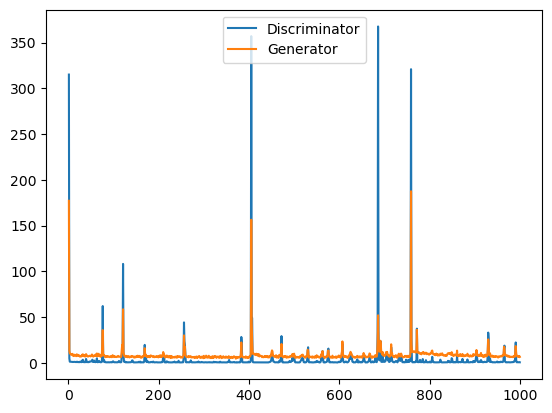

In [39]:
# let's look at the error graph and evaluate how the training is going
loss = torch.FloatTensor(losses)
fig, ax = plt.subplots()
ax.plot([i for i in range(1, len(losses)+1)], loss[:,0], label = 'Discriminator')
ax.plot([i for i in range(1, len(losses)+1)], loss[:,1], label = 'Generator')
ax.legend(loc='upper center')

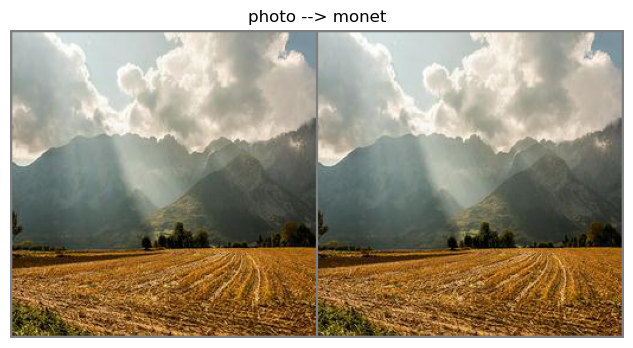

In [40]:
test_iter_X = iter(test_dataloader_X)
X_test = next(test_iter_X).to(device)
Y_test = G_X_Y(X_test)
grid_test = torchvision.utils.make_grid([X_test.squeeze(), Y_test.squeeze()], nrow = 2).permute(1, 2, 0).detach().cpu()
grid_test_denorm = denormalize(grid_test)
fig = plt.figure(figsize=(8, 4))
plt.imshow(grid_test_denorm)
plt.axis('off')
plt.title('photo --> monet')
plt.show()